In [1]:
%%javascript
// Making sure the outputs display correctly
//IPython.OutputArea.prototype._should_scroll = function(lines) {
//    return false;
//}

<IPython.core.display.Javascript object>

In [124]:
# Importing required packages for this homework
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
#from IPython.display import HTML, display
#import tabulate
%matplotlib inline

#Keep note of this rounding function.
## I use it throughout to change full float
## values to round to three decimal places.
def rounds(item):
    ret = float('%.3f'% (item * 1000/1000))
    return(ret)

In [2]:
# Atmospheric model created using the NASA equation found at:
# https://www.grc.nasa.gov/WWW/k-12/airplane/atmosmet.html
class atmosphere:
    def __init__(self, val, valGiven = 0,units = "SI"):
        #Convert from US to SI
        if units != "SI" and valGiven == 0:
            val = val / 3.281
        if units != "SI" and valGiven == 1:
            val = val * 0.04788
        #0 implies the given value is an altitude
        #1 implies the given value is a pressure
        if valGiven == 0:
            self.h = val
        elif valGiven == 1:
            self.P = val
        else:
            print("Not a valid 'valGiven' parameter.")
    def hCalc(self):
        if self.h < 11000:
            self.T = 15.04 - 0.00649*self.h #K
            self.P = 101.29 * ((self.T + 273.1)/288.08)**(5.256) #kPa
        elif self.h < 25000:
            self.T = -56.46
            self.P = 22.65 * np.exp(1.73 - 0.000157*self.h)
        elif self.h > 24999:
            self.T = -131.21 + 0.00299*self.h
            self.P = 2.488 * ((self.T + 273.1)/216.6)**(-11.388)
        self.rho = self.P / (0.2869 * (self.T + 273.1))
    def PCalc(self):
        if self.P > 22.632:
            self.T = (288.08*(self.P/101.29)**(1/5.256))-273.1
            self.h = (self.T - 15.04)/(-0.00649)
        elif self.P > 0.1113586:
            self.T = -56.46
            self.h = (1.73 - np.log((self.P/22.65)))/(0.000157)
        else:
            self.T = (216.6*(self.P/2.488)**(1/(-11.388)))-273.1
            self.h = (self.T + 131.21)/0.00299
        self.rho = self.P / (0.2869 * (self.T + 273.1))
# ISENTROPIC RELATIONS
def totPres(Ps, M,gamma=1.4):
    total = Ps * ((1+((gamma-1)/2)*M**2)**(gamma/(gamma-1)))
    return(total)
def statPres(Pt, M, gamma=1.4):
    static = Pt / ((1+((gamma-1)/2)*M**2)**(gamma/(gamma-1)))
    return(static)
def totTemp(Ts, M, gamma=1.4):
    total = Ts * ((1+((gamma-1)/2)*M**2))
    return(total)
def statTemp(Tt, M, gamma=1.4):
    static = Tt / ((1+((gamma-1)/2)*M**2))
    return(static) 

In [3]:
dynamicP = []
staticP = []
staticT = []
totalP = []
totalT = []
densities = []
machs = []
alts = np.linspace(30000,50000,1000)
q = 71820.375 #Pascals
for i in range(len(alts)):
    atmos = atmosphere(alts[i])
    atmos.hCalc()
    staticP.append(rounds(atmos.P*1000))
    qGuess,MGuess = 0,2.5
    while abs(qGuess-q) > 10:
        MGuess += 0.00005
        totGuess = totPres(staticP[i],MGuess)
        #print("totGuess: ", totGuess)
        qGuess = totGuess - staticP[i]
        #print(abs(qGuess-q))
            #print("it shoud break here")
        if MGuess > 15:
            break
    if MGuess > 10:
        print("fix something")
        break
    dynamicP.append(rounds(qGuess))
    totalP.append(rounds(totGuess))
    machs.append(rounds(MGuess))
    staticT.append(rounds(atmos.T+273.15))
    totalT.append(totTemp(atmos.T+273.15,MGuess))
    densities.append(atmos.rho)
    

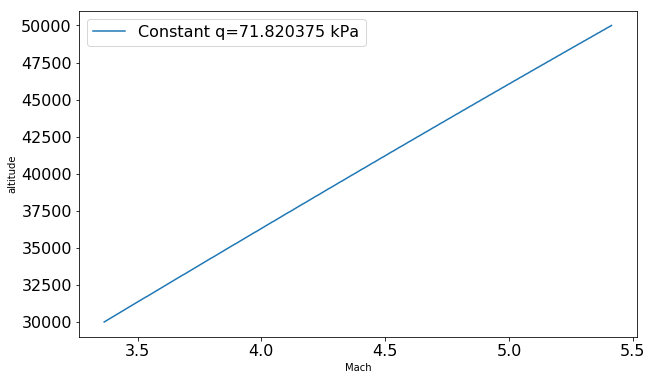

In [4]:
#GRAPHING TIME
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot(machs,alts,'-',label="Constant q=71.820375 kPa")

#plt.title('Mach number to altitude', fontsize=16)

#plt.ylim(0,1.5)
plt.ylabel('altitude')
plt.xlabel('Mach')
plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()

In [5]:
#Find the index of the mach 5 term
iVal = machs.index(min([abs(item-5) for item in machs])+5)

In [6]:
#Verify that this is, indeed, mach 5
print(machs[iVal])

5.001


In [7]:
#Printing off the data table
data = [["$M_0$","Input","5"],["Alpha","Input","0"],["Beta","Input","0"],
        ["$q_0$","input",71.8],["$H$","Calc",alts[iVal]],
        ["$P_0$","Calc",staticP[iVal]],
        ["$P_{t0}$","Calc",totalP[iVal]],["$T_0$","Calc",staticT[iVal]],
        ["$T_{t0}$","Calc",totalT[iVal]],
        ["$\rho_0$","Calc",densities[iVal]*1000]]
dataColumns = ["NOMENCLATURE","TYPE","Value"] #4
dataRows = ["Flight Mach Number","Angle of Attack ($rad$)","Yaw Angle ($rad$)",
            "Dynamic Pressure ($kPa$)","Altitude ($m$)",
            "Freestream Pressure\n ($kPa$)","Freestream Total Pressure ($kPa$)",
           "Freestream Temperature ($K$)", "Freestream Total Temperature ($K$)",
           "Freestream Density ($g/m^3$)"] #7
pd.DataFrame(data, columns=dataColumns, index=dataRows)


,NOMENCLATURE,TYPE,Value
Flight Mach Number,$M_0$,Input,5
Angle of Attack ($rad$),Alpha,Input,0
Yaw Angle ($rad$),Beta,Input,0
Dynamic Pressure ($kPa$),$q_0$,input,71.8
Altitude ($m$),$H$,Calc,46056.1
Freestream Pressure\n ($kPa$),$P_0$,Calc,135.896
Freestream Total Pressure ($kPa$),$P_{t0}$,Calc,71947.3
Freestream Temperature ($K$),$T_0$,Calc,279.648
Freestream Total Temperature ($K$),$T_{t0}$,Calc,1678.19
Freestream Density ($g/m^3$),$\rho_0$,Calc,1.69411


In [110]:
## PARAMETERS FROM ABOVE ##
T0 = staticT[iVal]
M0 = machs[iVal]
rho0 = densities[iVal]
#print("T0:",T0)

mDot1X = 10 / 2.205 #kg/s
mDot5X = mDot1X * 5
#print("mdot 5 (kg/s): ",mDot5X)
a = np.sqrt(1.41 * 287 * T0)
u = M0 * a
#print(u)
A3X = mDot1X*3 / (u*rho0)
A5X = mDot5X / (u*rho0)
#print("A3X: ", np.pi*((19.04*0.0254)/2)**2)
#print(A3X)
#print(A5X)

In [11]:
path = os.getcwd()
inletFile = pd.read_csv("inletmap.csv")
inletFile.head()

C:\Users\butle175\Downloads\AAE537-master


,Flight Mach Number,Angle of Attack (deg),Yaw Angle (deg),Dynamic Pressure (psf),Altitude (ft),Freestream Pressure (psia),Freestream Total Pressure (psia),Freestream Temperature (deg R),Freestream Total Temperature (deg R),Freestream Equilibrium Gamma,...,Unnamed: 30,Isolator Heat Loss (BTU/lbm),Isolator Exit Area (in^2),Normal Shock Pressure Ratio,Isolator Pressure Ratio,Unnamed: 35,Inlet Axial Force (lbf),Inlet Axial Force Coefficient,Inlet Normal Force (lbf),Inlet Normal Force Coefficient
0,M0,Alpha,Beta,q0,H,P0,Pt0,T0,Tt0,Gamma0,...,NaN,DeltaH2,A2,PR-NS,P2/P1,NaN,Faxial,Cfaxial,Fnormal,Cfnormal
1,Input,Input,Input,Input,Calculated,Calculated,Calculated,Calculated,Calculated,Calculated,...,NaN,Calculated,Fixed,Calculated,Calculated,NaN,Calculated,Derived,Calculated,Derived
2,4,-4,0,1500,62514,0.9301,148.2,390.0,1593,1.410,...,NaN,0.223,36.85,4.561,3.649,NaN,-547.2,-0.184,702.2,0.237
3,4,-2,0,1500,62514,0.9301,148.2,390.0,1593,1.410,...,NaN,0.212,36.85,3.983,3.186,NaN,-668.7,-0.225,918.7,0.309
4,4,0,0,1500,62514,0.9301,148.2,390.0,1593,1.410,...,NaN,0.201,36.85,3.466,2.773,NaN,-787.7,-0.265,1134.9,0.382


In [122]:
iF = inletFile
iF = iF.iloc[:,[0,1,23,24,25,26,27,28,29]]
iF = iF.drop(iF.index[[8,15,22,29,36,43]])
iF = iF.drop(iF.index[32:])
for j in range(len(iF.columns)):
    for i in range(len(iF.index)):
        if i > 1:
            if j < 2:
                continue
            elif j == 2 or j == 3:
                #print(i,j)
                iF.iloc[i,j] = float(iF.iloc[i,j]) * 6.89476 #Convert pressures into kPa
            elif j == 4 or j == 5:
                iF.iloc[i,j] = float(iF.iloc[i,j]) * (5/9) #Convert rankine to Kelvin
            elif j == 8:
                iF.iloc[i,j] = float(iF.iloc[i,j]) * 0.3048 #Convert feet/s to meters/s
            else:
                continue
        else:
            continue
iF.rename(columns = {'Throat Pressure (psia)':'Throat Pressure (kpa)',
                    'Throat Total Pressure (psia)':'Throat Total Pressure (kpa)',
                    'Throat Temperature (deg R)':'Throat Temperature (K)',
                    'Throat Total Temperature (deg R)':'Throat Total Temperature (K)',
                    'Throat Velocity (ft/s)':'Throat Velocity (m/s)'},
         inplace = True)
iF

,Flight Mach Number,Angle of Attack (deg),Throat Pressure (kpa),Throat Total Pressure (kpa),Throat Temperature (K),Throat Total Temperature (K),Throat Mach Number,Throat Gamma,Throat Velocity (m/s)
0,M0,Alpha,P1,Pt1,T1,Tt1,M1,Gamma1,V1
1,Input,Input,Calculated,Calculated,Calculated,Calculated,Calculated,Calculated,Calculated
2,4,-4,94.8719,766.697,506.222,885,2.016,1.381,903.122
3,4,-2,114.936,760.492,534.889,885,1.890,1.378,869.594
4,4,0,138.033,756.355,563.333,885,1.770,1.375,834.847
5,4,2,166.095,747.392,593.889,885,1.643,1.372,794.614
6,4,4,206.567,727.397,635,885,1.478,1.368,738.226
7,4,6,258.76,719.813,676.667,885,1.312,1.365,675.132
9,4.5,-4,73.1534,1132.81,510.278,1051.67,2.420,1.381,1088.14
10,4.5,-2,88.5977,1117.64,539.833,1051.67,2.293,1.378,1059.48


In [151]:
M2 = []
P2 = []
Pt2 = []
T2 = []
Tt2 = []
#Run through all rows of the dataframe
for i in range(len(iF.index)):
    # Don't do anything for the first two rows
    if i < 2:
        continue
    else:
        # Getting values from the current row of the datafram
        gamma = float(iF.iloc[i,7])
        mach = float(iF.iloc[i,0])
        P1 = float(iF.iloc[i,2])
        Pt1 = float(iF.iloc[i,3])
        T1 = float(iF.iloc[i,4])
        Tt1 = float(iF.iloc[i,5])
        # Normal Shock: Mach
        M2.append(
            rounds(np.sqrt( 
                (
                    ((gamma-1) * mach**2 + 2)/
                    (2*gamma * mach**2-(gamma-1))
                ) 
            )
        ))
        # Normal Shock: Total Temperature
        Tt2.append(rounds(Tt1))
        # Normal Shock: Total Pressure
        Pt_rat = (
            (((gamma+1) * mach**2)/((gamma-1) * mach**2 + 2))**(gamma/(gamma-1))*
            ((gamma+1)/(2*gamma*mach**2 - (gamma-1)))**(1/(gamma-1))
        )
        Pt2.append(rounds(Pt1 * Pt_rat))
        # Isentropic Relation: Static Pressure
        P2.append(rounds(statPres(Pt2[-1],M2[-1],gamma)))
        # Isentropioc Relation: Static Temperature
        T2.append(rounds(statTemp(Tt2[-1],M2[-1],gamma)))
endOfInlet = {'Freestream Mach':iF.iloc[2:,0],
             'Angle of Attack (deg)':iF.iloc[2:,1],
             'Exchanger Mach': M2,
             'Exchanger Static Pressure (kPa)':P2,
             'Exchanger Total Pressure (kPa)':Pt2,
             'Exchanger Static Temperature (K)':T2,
             'Exchanger Total Temperature (K)':Tt2}
#eE stands for exchanger Entrance (in camel case)
eE = pd.DataFrame(endOfInlet)
eE.head()
eE.to_csv(path+'\exchangerEntrance.csv', index=False)

In [152]:
#These next few code blocks are constructed to 
## generate a linear interpolation. This interpolation
## allows us to create a rough estimate of conditions
## below the mach 4 cruise condition.
def linReg(points):
    n = len(points)
    X = [item[0] for item in points]
    Y = [item[1] for item in points]
    Sx = sum(X)
    Sy = sum(Y)
    Sxx = sum([item**2 for item in X])
    Sxy = sum([X[i] * Y[i] for i in range(n)])
    Syy = sum([item**2 for item in Y])
    beta = rounds((n*Sxy - Sx * Sy)/
            (n*Sxx - Sx**2))
    alpha = rounds((1/n)*Sy - beta*(1/n)*Sx)
    print("Linear Regression: " + str(beta) + "x + " + str(alpha))
    return([beta,alpha])

In [180]:
presPoints = [[],[],[],[],[],[]]
for i in range(len(iF.index)):
    #print(i)
    if iF.iloc[i,1] == '-4':
        presPoints[0].append([
            float(iF.iloc[i,0]),iF.iloc[i,2]
        ])
    elif iF.iloc[i,1] == '-2':
        presPoints[1].append([
            float(iF.iloc[i,0]),iF.iloc[i,2]
        ])
    elif iF.iloc[i,1] == '0':
        presPoints[2].append([
            float(iF.iloc[i,0]),iF.iloc[i,2]
        ])
    elif iF.iloc[i,1] == '2':
        presPoints[3].append([
            float(iF.iloc[i,0]),iF.iloc[i,2]
        ])
    elif iF.iloc[i,1] == '4':
        presPoints[4].append([
            float(iF.iloc[i,0]),iF.iloc[i,2]
        ])
    elif iF.iloc[i,1] == '6':
        presPoints[5].append([
            float(iF.iloc[i,0]),iF.iloc[i,2]
        ])
print(presPoints)
fPres = [linReg(item) for item in presPoints]

[[[4.0, 94.8718976], [4.5, 73.15340359999999], [5.0, 59.77067444], [5.5, 50.66959124], [6.0, 44.02993736]], [[4.0, 114.93564920000001], [4.5, 88.59766599999999], [5.0, 72.9465608], [5.5, 62.211419479999996], [6.0, 54.49618304]], [[4.0, 138.0330952], [4.5, 105.5587756], [5.0, 87.28766159999999], [5.5, 75.0149888], [6.0, 66.34827548]], [[4.0, 166.0947684], [4.5, 125.0709464], [5.0, 103.2835048], [5.5, 88.5287184], [6.0, 78.32447359999999]], [[4.0, 206.5670096], [4.5, 148.926816], [5.0, 121.8304092], [5.5, 104.80035199999999], [6.0, 93.3550504]], [[4.0, 258.7603428], [4.5, 174.36848039999998], [5.0, 141.2046848], [5.5, 121.4167236], [6.0, 108.5235224]]]
Linear Regression: -24.834x + 188.669
Linear Regression: -29.453x + 225.902
Linear Regression: -34.783x + 268.364
Linear Regression: -42.417x + 324.345
Linear Regression: -54.11x + 405.646
Linear Regression: -70.685x + 514.28
[[-24.834, 188.669], [-29.453, 225.902], [-34.783, 268.364], [-42.417, 324.345], [-54.11, 405.646], [-70.685, 514.2

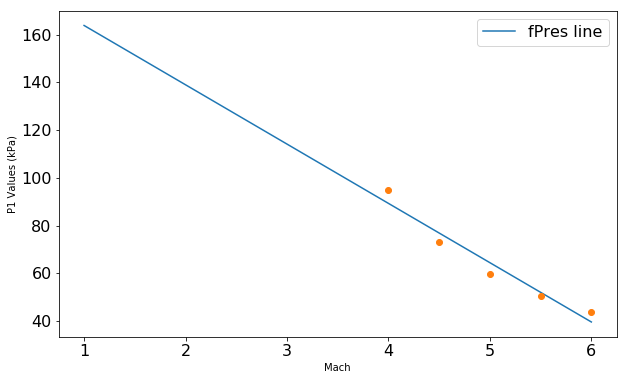

In [183]:
#GRAPHING TIME
x = np.linspace(1,6,20)

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot(x,[item*fPres[0][0] + fPres[0][1] for item in x],'-',label="fPres line")
plt.plot([item[0] for item in presPoints[0]], [item[1] for item in presPoints[0]],'o')

#plt.title('Mach number to altitude', fontsize=16)

#plt.ylim(0,1.5)
plt.ylabel('P1 Values (kPa)')
plt.xlabel('Mach')
plt.legend(loc=1, fontsize=16)

plt.show()
plt.close()